In [105]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Project 2

### Generative AI
### Jack Bosco
### Working with GANS

---

1. ### Dataset Preparation 

	- Download and load the Fashion-MNIST dataset using `torchvision.datasets.FashionMNIST`
	- Normalize the images to have values between -1 and 1, as this range typically works well with the ReLU activation function used in the generator's layers.
	- Create DataLoader objects for the training dataset to iterate over batches.

In [106]:
# define the transforms to values between -1 and 1
transform = transforms.Compose(
	[
		transforms.ToTensor()
		, transforms.Normalize((.5), (.5), inplace=True) # normalize between -1 and 1
  	]
)

batchsize = 32

# load the training dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False, num_workers=2)

# define the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Visualize the data

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor(-1.) tensor(1.)


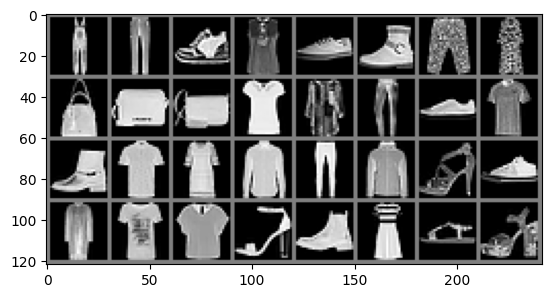

|     Trouser     |     Trouser     |     Sneaker     |      Shirt      |     Sneaker     |   Ankle boot    |     Trouser     |      Dress      |       Bag       |       Bag       |       Bag       |   T-shirt/top   |      Shirt      |     Trouser     |     Sneaker     |   T-shirt/top   |   Ankle boot    |   T-shirt/top   |      Dress      |      Shirt      |     Trouser     |      Coat       |     Sandal      |     Sneaker     |      Dress      |   T-shirt/top   |      Shirt      |     Sandal      |   Ankle boot    |      Dress      |     Sandal      |     Sandal      |


In [107]:
# print some info about a sample from the data
e = next(iter(trainloader))
print(e[0].shape, e[1].shape)
print(e[0].min(), e[0].max())

# show some images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
	img = img / 2 + 0.5 # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()

imshow(torchvision.utils.make_grid(e[0]))
s = '|' + r'{:^17s}|' * batchsize
print(s.format(*[classes[e[1][j]] for j in range(batchsize)]))

### 2. Make the GAN Archetecture

The generator uses batch normalization `BatchNorm1d` to stabilize training.

The discriminator uses `LeakyReLU` activations to prevent gradients from vanishing.

In [108]:
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#dev = torch.device('cpu')

In [109]:
# Generator Model
from zmq import device


class Generator(nn.Module):
	def __init__(self, latent_dim, img_shape, device=dev):
		super(Generator, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(latent_dim, 128),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(128, 256),
			nn.BatchNorm1d(256, 0.8, device=dev),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(256, 512),
			nn.BatchNorm1d(512, 0.8, device=dev),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, 1024),
			nn.BatchNorm1d(1024, 0.8, device=dev),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(1024, int(np.prod(img_shape))),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		img = img.view(img.size(0), *img_shape)
		return img

# Discriminator Model
class Discriminator(nn.Module):
	def __init__(self, img_shape):
		super(Discriminator, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(int(np.prod(img_shape)), 1024),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(1024, 512),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, 256),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(256, 1),
			nn.Sigmoid()
		)

	def forward(self, img):
		img_flat = img.view(img.size(0), -1)
		validity = self.model(img_flat)
		return validity

# Initialize the models
latent_dim = 100 # Size of the latent vector (input noise)
img_shape = (1, 28, 28) # Fashion-MNIST images are 28x28 pixels in grayscale

generator = Generator(latent_dim=latent_dim, img_shape=img_shape).to(dev)
discriminator = Discriminator(img_shape).to(dev)

# Loss function and optimizer
loss_fn = nn.BCELoss() # Binary cross entropy loss
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, .999), eps=2e-6, weight_decay=1e-12, amsgrad=True)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, .999), eps=2e-5, weight_decay=1e-10)

### 4. Training Loop

- For each epoch, iterate over the DataLoader of the training dataset.

- For each batch, perform the following steps:

- Maximize the log probability of correctly classifying both real and generated images.

- Update the generator to minimize the log probability of the discriminator being correct (i.e., encourage it to generate better fakes).

- Save model checkpoints at regular intervals.

Epoch 1/25, Batch 937/1875, G Loss: 1.905, D Loss: 0.522
Epoch 1/25, Batch 1874/1875, G Loss: 1.146, D Loss: 0.496
Generated Images


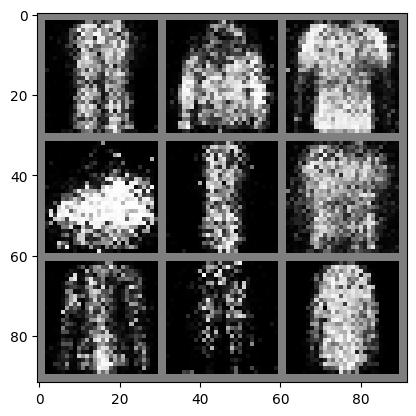

Epoch 2/25, Batch 937/1875, G Loss: 1.014, D Loss: 0.589
Epoch 2/25, Batch 1874/1875, G Loss: 1.125, D Loss: 0.569
Generated Images


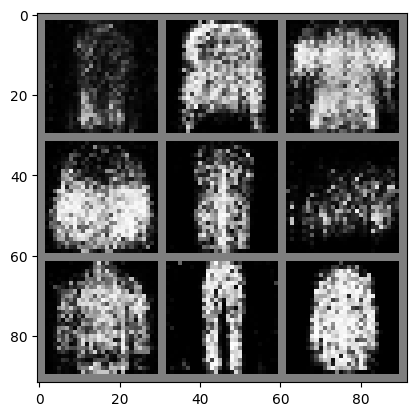

Epoch 3/25, Batch 937/1875, G Loss: 0.963, D Loss: 0.576
Epoch 3/25, Batch 1874/1875, G Loss: 1.073, D Loss: 0.581
Generated Images


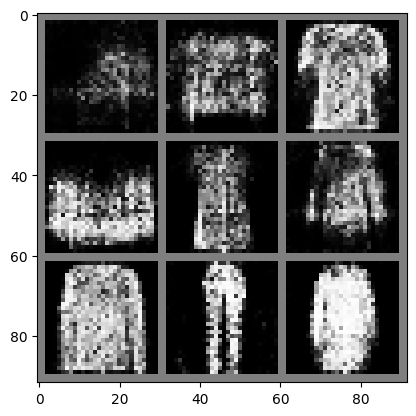

Epoch 4/25, Batch 937/1875, G Loss: 0.932, D Loss: 0.636
Epoch 4/25, Batch 1874/1875, G Loss: 0.912, D Loss: 0.609
Generated Images


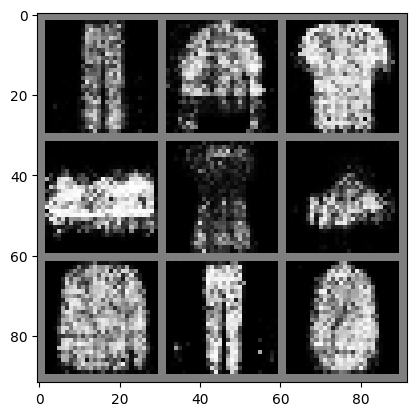

Epoch 5/25, Batch 937/1875, G Loss: 1.368, D Loss: 0.607
Epoch 5/25, Batch 1874/1875, G Loss: 0.771, D Loss: 0.559
Generated Images


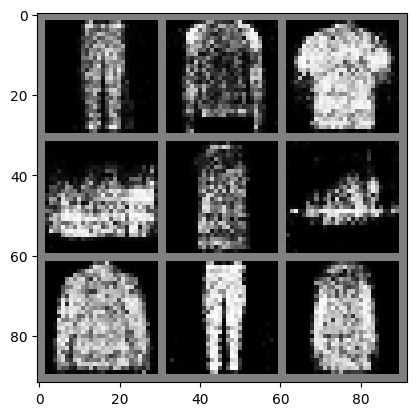

Epoch 6/25, Batch 937/1875, G Loss: 1.150, D Loss: 0.504
Epoch 6/25, Batch 1874/1875, G Loss: 1.064, D Loss: 0.560
Generated Images


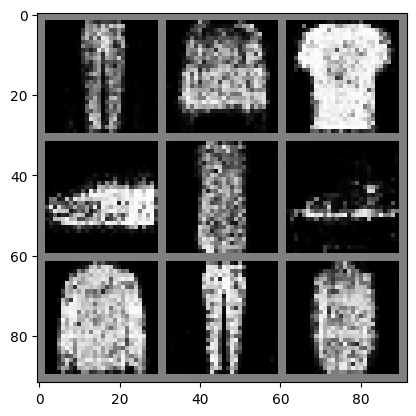

Epoch 7/25, Batch 937/1875, G Loss: 1.141, D Loss: 0.621
Epoch 7/25, Batch 1874/1875, G Loss: 1.391, D Loss: 0.508
Generated Images


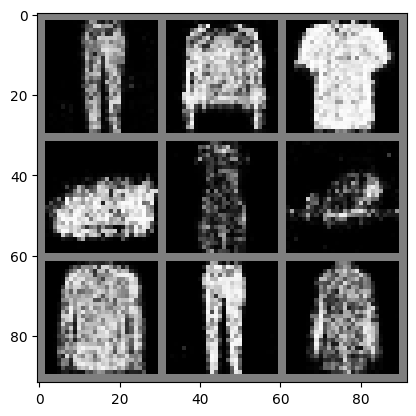

Epoch 8/25, Batch 937/1875, G Loss: 1.162, D Loss: 0.498
Epoch 8/25, Batch 1874/1875, G Loss: 1.026, D Loss: 0.598
Generated Images


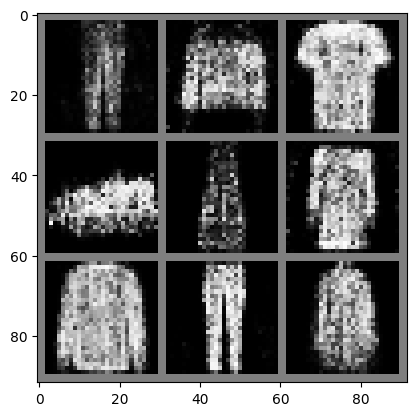

Epoch 9/25, Batch 937/1875, G Loss: 1.093, D Loss: 0.557
Epoch 9/25, Batch 1874/1875, G Loss: 1.323, D Loss: 0.566
Generated Images


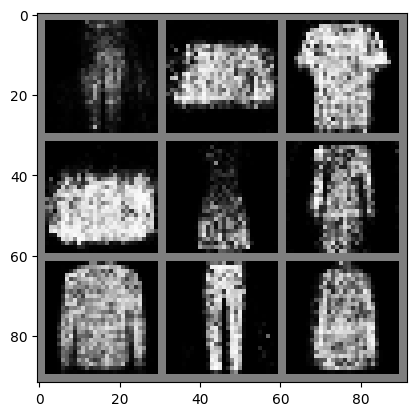

Epoch 10/25, Batch 937/1875, G Loss: 0.960, D Loss: 0.582
Epoch 10/25, Batch 1874/1875, G Loss: 0.949, D Loss: 0.576
Generated Images


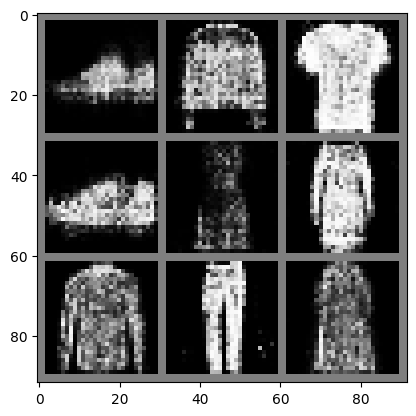

Epoch 11/25, Batch 937/1875, G Loss: 0.882, D Loss: 0.581
Epoch 11/25, Batch 1874/1875, G Loss: 1.058, D Loss: 0.490
Generated Images


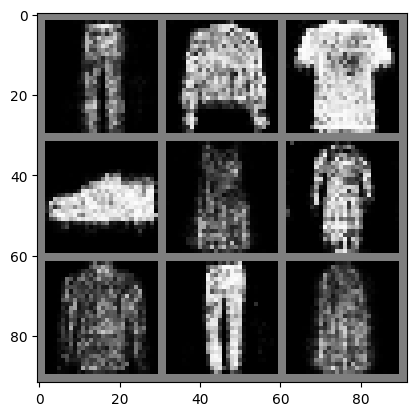

Epoch 12/25, Batch 937/1875, G Loss: 1.028, D Loss: 0.581
Epoch 12/25, Batch 1874/1875, G Loss: 0.919, D Loss: 0.557
Generated Images


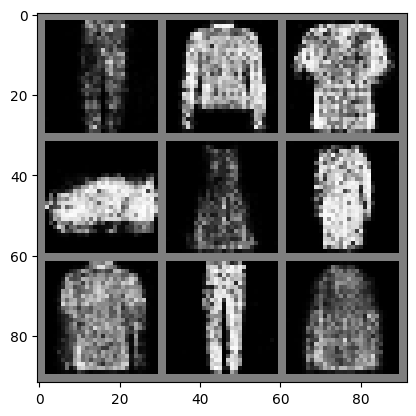

Epoch 13/25, Batch 937/1875, G Loss: 1.168, D Loss: 0.567
Epoch 13/25, Batch 1874/1875, G Loss: 1.283, D Loss: 0.541
Generated Images


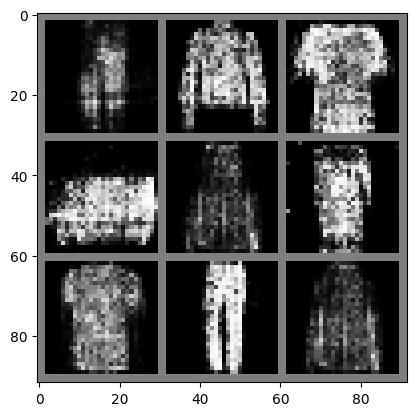

Epoch 14/25, Batch 937/1875, G Loss: 1.185, D Loss: 0.603
Epoch 14/25, Batch 1874/1875, G Loss: 0.900, D Loss: 0.518
Generated Images


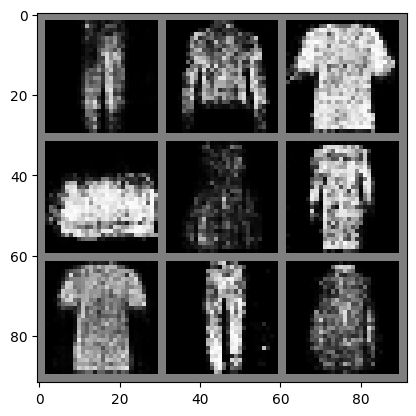

Epoch 15/25, Batch 937/1875, G Loss: 1.231, D Loss: 0.547
Epoch 15/25, Batch 1874/1875, G Loss: 0.958, D Loss: 0.627
Generated Images


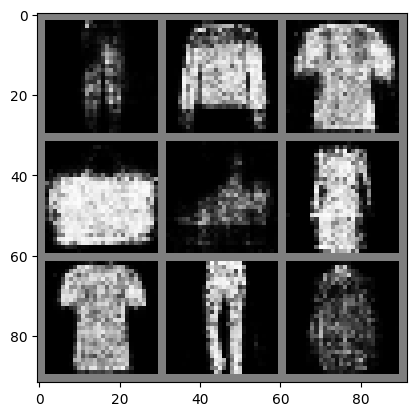

Epoch 16/25, Batch 937/1875, G Loss: 1.235, D Loss: 0.614
Epoch 16/25, Batch 1874/1875, G Loss: 1.270, D Loss: 0.615
Generated Images


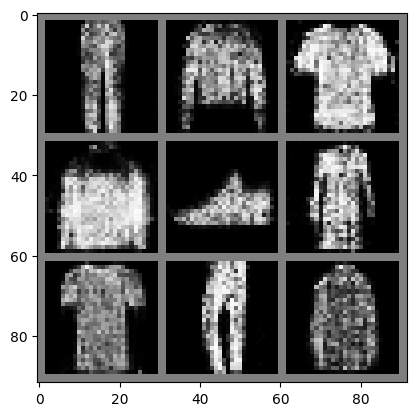

Epoch 17/25, Batch 937/1875, G Loss: 0.983, D Loss: 0.528
Epoch 17/25, Batch 1874/1875, G Loss: 1.115, D Loss: 0.600
Generated Images


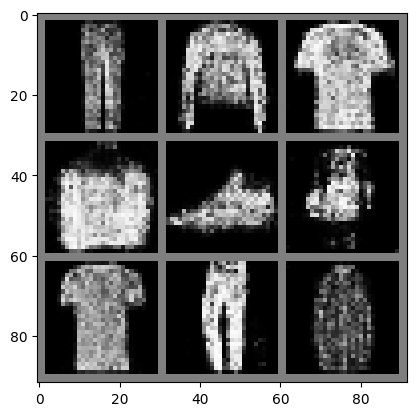

Epoch 18/25, Batch 937/1875, G Loss: 1.057, D Loss: 0.548
Epoch 18/25, Batch 1874/1875, G Loss: 1.287, D Loss: 0.539
Generated Images


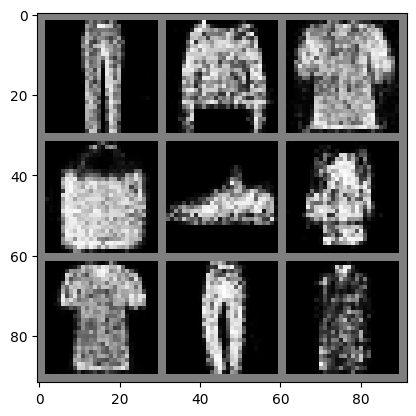

Epoch 19/25, Batch 937/1875, G Loss: 0.986, D Loss: 0.512
Epoch 19/25, Batch 1874/1875, G Loss: 0.769, D Loss: 0.608
Generated Images


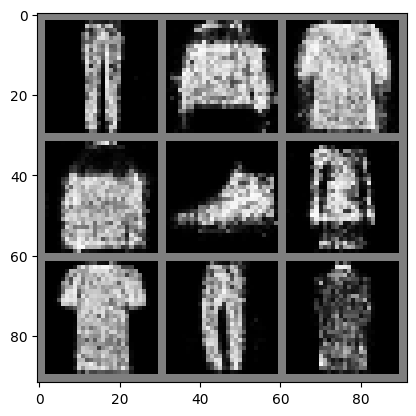

Epoch 20/25, Batch 937/1875, G Loss: 1.012, D Loss: 0.509
Epoch 20/25, Batch 1874/1875, G Loss: 1.184, D Loss: 0.592
Generated Images


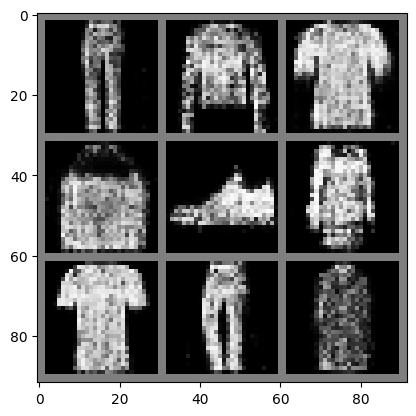

Epoch 21/25, Batch 937/1875, G Loss: 1.071, D Loss: 0.632
Epoch 21/25, Batch 1874/1875, G Loss: 1.006, D Loss: 0.636
Generated Images


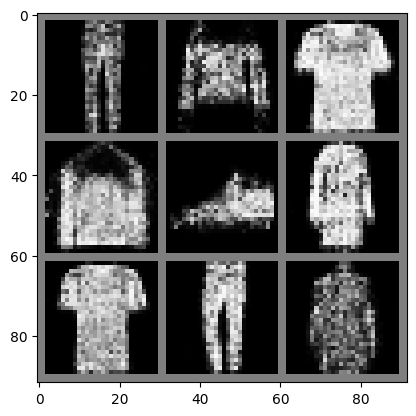

Epoch 22/25, Batch 937/1875, G Loss: 1.260, D Loss: 0.579
Epoch 22/25, Batch 1874/1875, G Loss: 1.093, D Loss: 0.545
Generated Images


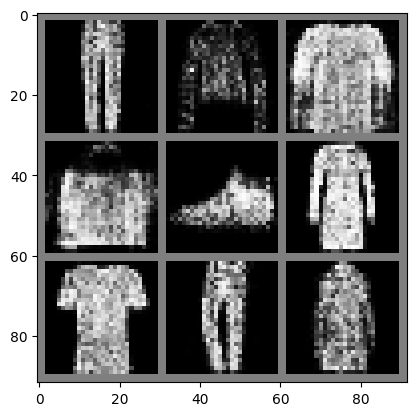

Epoch 23/25, Batch 937/1875, G Loss: 1.104, D Loss: 0.537
Epoch 23/25, Batch 1874/1875, G Loss: 1.270, D Loss: 0.539
Generated Images


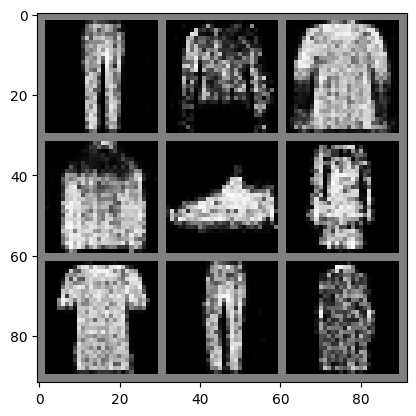

Epoch 24/25, Batch 937/1875, G Loss: 1.202, D Loss: 0.561
Epoch 24/25, Batch 1874/1875, G Loss: 1.203, D Loss: 0.518
Generated Images


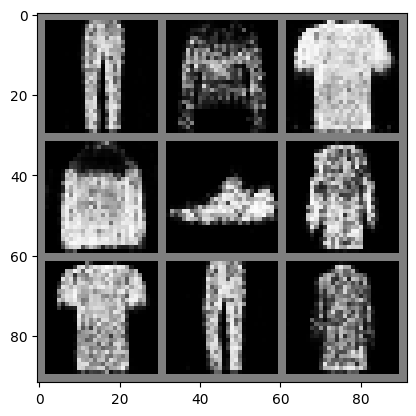

Epoch 25/25, Batch 937/1875, G Loss: 1.158, D Loss: 0.504
Epoch 25/25, Batch 1874/1875, G Loss: 1.210, D Loss: 0.549
Generated Images


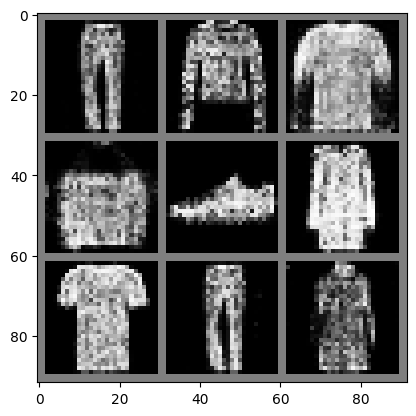

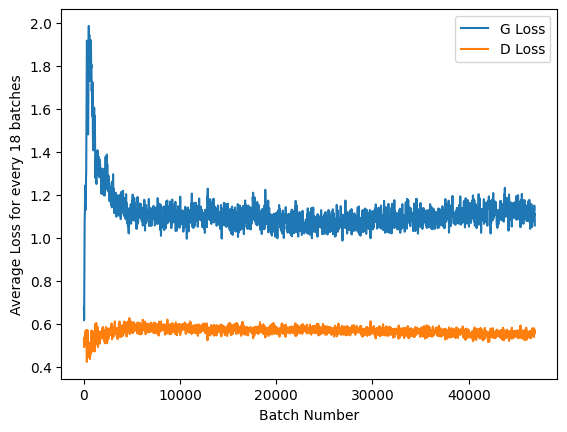

In [110]:
from audioop import lin2adpcm
from colorsys import rgb_to_hls
from matplotlib.colors import rgb2hex
from scipy.interpolate import make_interp_spline
def train(dataloader, epochs, batchsize, latent_dim):
	z_show = torch.randn(9, latent_dim).to(dev) # fixed sample noise for visualization
	avg_loss = {'G Loss': [], 'D Loss': [], 'batchnum': []}
	rg_loss, rd_loss, batches = 0, 0, 0
	for epoch in range(epochs): #loop over the dataset for each epoch
		for i, (imgs, labels) in enumerate(dataloader): #loop for each batch
			valid = torch.ones(batchsize, 1).to(dev)
			fake = torch.zeros(batchsize, 1).to(dev)

			# generate some images
			z = torch.randn(batchsize, latent_dim).to(dev) # Sample noise as generator input
			gen_imgs = generator(z)

			# Train Discriminator
			discriminator.zero_grad()
			# concatenate the real and fake images
			both = torch.cat((imgs.to(dev), gen_imgs.detach()), 0)
			# get the discriminator loss as the loglog likelihood of the real and fake images
			both_loss = loss_fn(discriminator(both), torch.cat((valid, fake), 0))
			# backpropagate the loss
			both_loss.backward()
			# update the weights
			optimizer_D.step()

			# Train Generator
			generator.zero_grad()
			#generate more fake images
			z_t = torch.randn(batchsize*2, latent_dim).to(dev)
			valid_t = torch.ones(batchsize*2, 1).to(dev)
			gen_imgs_t = generator(z_t)

			# get the discriminator loss
			y_t = discriminator(gen_imgs_t).to(dev)
			g_loss = loss_fn(y_t, valid_t)
			# Train Generator
			g_loss.backward()
			optimizer_G.step()

			# running_loss['G Loss'].append(g_loss.item())
			# running_loss['D Loss'].append(both_loss.item())
			# running_loss['batchnum'].append(i + len(dataloader)//batchsize * (epoch))
			rg_loss += g_loss.item()
			rd_loss += both_loss.item()
			batches += 1

			# save the losses
			if (i+1) % (len(dataloader)//2)== 0:
				print(f'Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(dataloader)}, G Loss: {g_loss.item():.3f}, D Loss: {both_loss.item():.3f}')
			if (i+1) % (len(dataloader)//100)== 0:
				bnum = i + len(dataloader)//batchsize * (epoch)
				avg_loss['G Loss'].append(rg_loss / batches)
				avg_loss['D Loss'].append(rd_loss / batches)
				avg_loss['batchnum'].append(i + ( (len(dataloader))*epoch ))
				rg_loss, rd_loss, batches = 0, 0, 0
		# print generated images
		#avg_loss['G Loss'].append(sum(running_loss['G Loss']) / len(running_loss['G Loss']))
		#avg_loss['D Loss'].append(sum(running_loss['D Loss']) / len(running_loss['D Loss']))
		gen_imgs = generator(z_show)
		print('Generated Images')
		imshow(torchvision.utils.make_grid(gen_imgs.cpu().detach(), nrow=3))

	loss_df = pd.DataFrame(avg_loss)
	loss_df.index = loss_df['batchnum']
	loss_df.sort_index(inplace=True)
	plt.plot(loss_df['G Loss'], label='G Loss')
	plt.plot(loss_df['D Loss'], label='D Loss')
	plt.legend()
	plt.ylabel(f'Average Loss for every {len(dataloader)//100} batches')
	plt.xlabel('Batch Number')
	plt.show()
	plt.savefig('loss.jpeg')
	plt.close()
	

train(trainloader, 25, batchsize, latent_dim)

In [111]:
# save the generator model
torch.save(generator.state_dict(), 'generator.pth')